###### load and preview the merged and reducted df

In [55]:
# Data Loading & Basic Inspection
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("wavesData_100k.csv")  # Replace with correct file path
# Just check basics
print(f"Shape: {df.shape}")
print(f"Missing values:\n {df.isnull().sum()}")
print(f"Column types: \n{df.dtypes}")
print(f"Time range per patient:\n {df.groupby('pID')['time'].agg(['min', 'max']).head()}")

Shape: (100000, 9)
Missing values:
 time                 0
paw                  0
flow                 0
vol                  0
pmus                 0
pID                  0
segment_id           0
global_segment_id    0
segment_range        0
dtype: int64
Column types: 
time                 float64
paw                  float64
flow                 float64
vol                  float64
pmus                 float64
pID                    int64
segment_id             int64
global_segment_id     object
segment_range         object
dtype: object
Time range per patient:
        min     max
pID               
0    50.02  146.94
1     9.04  154.69
2     2.96  159.17
3    31.07  162.23
4    45.73  102.39


##### 1. Clean data and ensure it's quality

In [59]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import medfilt

# --- CONFIGURATION ---
# IMPORTANT: Replace this with your actual data path
SAMPLING_RATE_HZ = 50.0  # Common for ventilators (e.g., 50 Hz)
SAMPLING_INTERVAL_S = 1 / SAMPLING_RATE_HZ

# Smoothing parameters
SMOOTHING_WINDOW = int(0.15 / SAMPLING_INTERVAL_S) # Window size for 150ms smoothing
FLOW_THRESHOLD = 0.1 # L/min, minimum flow to register as inspiration start
# ---------------------

# ==============================================================================
# 1. DATA CLEANING AND PREPARATION FUNCTIONS
# ==============================================================================

def clean_data(df):
    """Handles missing values, large outliers, and applies smoothing."""
    print("--- 1. Starting Data Cleaning ---")

    # 1. Handle Missing Values (Nulls)
    # Use linear interpolation to maintain time-series continuity
    initial_nulls = df.isnull().sum().sum()
    df = df.interpolate(method='linear', limit_direction='both')
    print(f"  > Interpolated {initial_nulls} NaN values.")

    # 2. Outlier Removal (using Median Filter for sudden spikes)
    for col in ['paw', 'flow', 'vol']:
        # Median filter is great for removing sharp spikes (outliers) without
        # distorting the signal shape much.
        df[col] = medfilt(df[col].values, kernel_size=3)
    print("  > Applied median filter for spike removal.")

    # 3. Signal Smoothing (Critical for accurate segmentation)
    # Use a rolling mean on 'flow' and 'paw'
    df['flow_smoothed'] = df['flow'].rolling(
        window=SMOOTHING_WINDOW, center=True, min_periods=1
    ).mean()
    df['paw_smoothed'] = df['paw'].rolling(
        window=SMOOTHING_WINDOW, center=True, min_periods=1
    ).mean()
    print(f"  > Applied rolling mean smoothing (Window: {SMOOTHING_WINDOW} samples).")

    # 4. Baseline Correction (Focus on Flow)
    # Subtract the overall mean flow, or a long-window minimum, to center the signal
    # A simple mean is often enough to remove overall signal drift
    df['flow_corrected'] = df['flow_smoothed'] - df['flow_smoothed'].mean()
    print("  > Completed baseline correction on flow.")

    return df

# ==============================================================================
# MAIN EXECUTION
# ==============================================================================

# 1. Load Data

# Ensure mandatory columns exist (Time, Paw, Flow, Vol)
if not all(col in df.columns for col in ['time', 'paw', 'flow', 'vol']):
    print("Error: DataFrame must contain 'time', 'paw', 'flow', and 'vol' columns.")
    exit()

print(f"Loaded {len(df):,} total raw data points.")

# 2. Clean Data
df_cleaned = clean_data(df)
print("-" * 40)


##### 2. Identitfy each breath in single component

In [ ]:
# ==============================================================================
# 2. SEGMENTATION FUNCTION (BREATH IDENTIFICATION)
# ==============================================================================

def segment_breaths(df, flow_col='flow_corrected', threshold=FLOW_THRESHOLD):
    """
    Segments the continuous data into individual breath segments.
    A breath cycle starts at the onset of inspiration (Flow > threshold).
    """
    print("--- 2. Starting Breath Segmentation ---")
    breath_segments = []

    # Identify where the flow crosses the threshold (Inspiration Start)
    flow_is_positive = df[flow_col] > threshold

    # Find indices where flow_is_positive flips from 0 (False) to 1 (True)
    # This marks the start of a new inspiration
    inspiration_starts = df.index[flow_is_positive.diff() == 1.0].tolist()

    # Include the very first data point if it's already an inspiration
    if flow_is_positive.iloc[0]:
        inspiration_starts.insert(0, df.index[0])

    # Create segments based on start indices
    for i in range(len(inspiration_starts)):
        start_idx = inspiration_starts[i]

        # The current breath ends just before the next one starts
        if i < len(inspiration_starts) - 1:
            end_idx = inspiration_starts[i+1]
        else:
            # Last breath runs to the end of the dataset
            end_idx = df.index[-1] + 1

        segment = df.loc[start_idx:end_idx - 1].copy()
        segment['breath_id'] = i  # Assign a unique ID

        # Only keep segments long enough to be a real breath
        if len(segment) * SAMPLING_INTERVAL_S > 0.5: # e.g., minimum 0.5 seconds long
            breath_segments.append(segment)

    df_segmented = pd.concat(breath_segments)
    print(f"  > Total raw data points segmented: {len(df_segmented):,}")

    return df_segmented


# 3. Segment Breaths
df_segmented = segment_breaths(df_cleaned)
print("-" * 40)


##### 1. Features engineering for the data

In [ ]:
# ==============================================================================
# 3. FEATURE EXTRACTION FUNCTION
# ==============================================================================

def extract_features(breath_group):
    """
    Extracts fixed-length, domain-specific and statistical features from a single breath.
    """

    # Ensure breath is not tiny
    if len(breath_group) < 5:
        return pd.Series({})

    # --- Time & Cycle Features ---
    # Duration of inspiration (flow > 0.1)
    insp_phase = breath_group[breath_group['flow_corrected'] > FLOW_THRESHOLD]
    Ti = len(insp_phase) * SAMPLING_INTERVAL_S

    # Total Cycle Time (Ttot)
    Ttot = len(breath_group) * SAMPLING_INTERVAL_S
    Te = Ttot - Ti # Expiratory Time

    # --- Pressure & Volume Features ---
    PIP = breath_group['paw'].max()
    PEEP_base = breath_group['paw'].iloc[-1] # Pressure at end of expiration

    Driving_Pressure = PIP - PEEP_base

    # --- Diagnostic Flow Features ---
    Peak_Expiratory_Flow = breath_group['flow'].min()

    # Key feature for Auto-PEEP or Triggering issues
    End_Expiratory_Flow = breath_group['flow_corrected'].iloc[-1]

    # Proxy for Volume Leak/Imbalance
    Inspired_Vol = breath_group['vol'].max() - breath_group['vol'].min()
    # Use Vol difference at breath boundaries (proxy for total exhaled vol)
    Volume_Difference_Net = breath_group['vol'].iloc[-1] - breath_group['vol'].iloc[0]


    # --- Statistical Features Helper ---
    def calculate_stats(series, prefix):
        return {
            f'{prefix}_stdev': series.std(),
            f'{prefix}_skew': skew(series),
            f'{prefix}_kurtosis': kurtosis(series)
        }

    # --- Final Feature Dictionary ---
    features = {
        # Primary Clinical Features
        'PIP': PIP,
        'PEEP_base': PEEP_base,
        'Driving_Pressure': Driving_Pressure,

        # Cycle Timing Features
        'Ti': Ti,
        'Te': Te,
        'Ttot': Ttot,
        'IE_Ratio': Ti / Te if Te > 0.001 else 999.0,

        # Flow/Volume Diagnostic Features
        'Peak_Expiratory_Flow': Peak_Expiratory_Flow,
        'End_Expiratory_Flow': End_Expiratory_Flow, # Check for Auto-PEEP
        'Inspired_Vol': Inspired_Vol,
        'Volume_Difference_Net': Volume_Difference_Net, # Check for leaks

        # Statistical Features
        **calculate_stats(breath_group['paw'], 'Paw'),
        **calculate_stats(breath_group['flow'], 'Flow'),
        **calculate_stats(breath_group['vol'], 'Vol')
    }

    return pd.Series(features)


# 4. Extract Features
print("--- 3. Starting Feature Extraction ---")
df_features = df_segmented.groupby('breath_id').apply(
    extract_features
).reset_index()

##### Review work done for now

In [ ]:
# Final cleanup of any failed feature rows
df_features.dropna(inplace=True)

# 5. Summary and Output
total_breaths = len(df_features)
print(f"FINAL RESULT: Successfully extracted features for {total_breaths:,} individual breaths.")
print(f"Feature Matrix Shape: {df_features.shape}")

# Save the resulting feature matrix for the next steps (Labeling/Modeling)
OUTPUT_PATH = 'unlabeled_breath_features.csv'
df_features.to_csv(OUTPUT_PATH, index=False)
print(f"\nSaved feature matrix to: {OUTPUT_PATH}")

# Display the first few rows of the final feature matrix
print("\nFirst 5 Breaths (Feature Matrix Head):")
print(df_features.head())

##### everything under this cell is comment and suggestion need to work on...

In [54]:
# total duration PER PATIENT
patient_durations = df.groupby('pID')['time'].max().reset_index()
patient_durations.columns = ['pID', 'total_duration']

# Merge back into main dataframe
df = df.merge(patient_durations, on='pID')

# Extract segment start time from segment_range
# Assuming segment_range looks like "50.0-70.0s"
df['segment_start'] = df['segment_range'].str.split('-').str[0].str.replace('s', '').astype(float)

# Now apply the function correctly
def get_clinical_phase(start_time, total_duration):
    if start_time < 60:
        return 'stabilization'
    elif start_time > total_duration - 60:
        return 'late_phase'
    else:
        return 'steady_state'

df['clinical_phase'] = df.apply(lambda x: get_clinical_phase(x['segment_start'], x['total_duration']), axis=1)


In [44]:
print("Clinical Phase Distribution:")
print(df['clinical_phase'].value_counts())

print("\nPatient duration statistics:")
print(df.groupby('pID')['total_duration'].describe())

Clinical Phase Distribution:
clinical_phase
late_phase       48250
stabilization    41000
steady_state     10750
Name: count, dtype: int64

Patient duration statistics:
      count    mean           std     min     25%     50%     75%     max
pID                                                                      
0    1000.0  146.94  2.843593e-14  146.94  146.94  146.94  146.94  146.94
1    1000.0  154.69  2.843593e-14  154.69  154.69  154.69  154.69  154.69
2    1000.0  159.17  0.000000e+00  159.17  159.17  159.17  159.17  159.17
3    1000.0  162.23  2.843593e-14  162.23  162.23  162.23  162.23  162.23
4    1000.0  102.39  2.843593e-14  102.39  102.39  102.39  102.39  102.39
..      ...     ...           ...     ...     ...     ...     ...     ...
95   1000.0  137.43  5.687186e-14  137.43  137.43  137.43  137.43  137.43
96   1000.0  162.16  0.000000e+00  162.16  162.16  162.16  162.16  162.16
97   1000.0  180.79  0.000000e+00  180.79  180.79  180.79  180.79  180.79
98   1000.0  139.

Segment start time distribution:
count    100000.000000
mean         76.524250
std          46.797593
min           0.800000
25%          35.075000
50%          79.850000
75%         113.950000
max         189.500000
Name: segment_start, dtype: float64


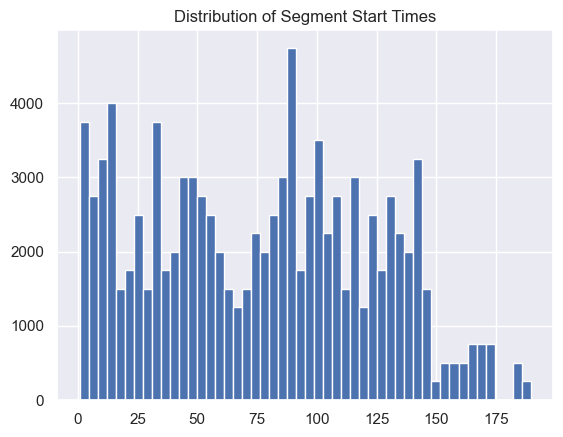

In [49]:
# Instead of random sampling, use stratified sampling by phase
phases_needed = {
    'stabilization': 250,  # 25% of segments
    'steady_state': 500,   # 50% of segments
    'late_phase': 250      # 25% of segments
}

# How were segments actually selected?
print("Segment start time distribution:")
print(df['segment_start'].describe())

# Plot segment start times
plt.hist(df['segment_start'], bins=50)
plt.title('Distribution of Segment Start Times')
plt.show()

In [51]:
# For patients with < 120s total duration, use different strategy
short_patients = patient_durations[patient_durations['total_duration'] < 120]
print(f"Short recordings: {len(short_patients)} patients")

# For these, maybe take 2 longer segments instead of 4 short ones

Short recordings: 24 patients


In [47]:
# Verify this isn't duplicated/synthetic data
print("Unique time sequences per patient:")
for pid in df['pID'].unique()[:5]:
    patient_times = df[df['pID'] == pid]['time']
    print(f"Patient {pid}: {patient_times.nunique()} unique time points")


# Check if your known anomalies are distributed across phases
# If 80% of anomalies are in 'stabilization', then oversampling that phase is GOOD

Unique time sequences per patient:
Patient 0: 1000 unique time points
Patient 1: 1000 unique time points
Patient 2: 1000 unique time points
Patient 3: 852 unique time points
Patient 4: 1000 unique time points
